In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("preritbhagat/stress-non-stress-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stress-non-stress-images


In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121, ResNet50
sns.set()

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory = '/kaggle/input/stress-non-stress-images/KDEF/KDEF/Train',
    batch_size = 32, 
    image_size = (80, 80), 
    shuffle = True
)

Found 4409 files belonging to 2 classes.


In [4]:
print('The number of batches in the training dataset is:', len(dataset))
for images, labels in dataset.take(1):
    print('The size of each batches is:', len(images))
    print('The size of each image is:', images[0].shape)
print('The number of classes in the dataset is:', len(dataset.class_names))
print('The classes in the dataset are:', dataset.class_names)

The number of batches in the training dataset is: 138
The size of each batches is: 32
The size of each image is: (80, 80, 3)
The number of classes in the dataset is: 2
The classes in the dataset are: ['NoStress', 'Stress']


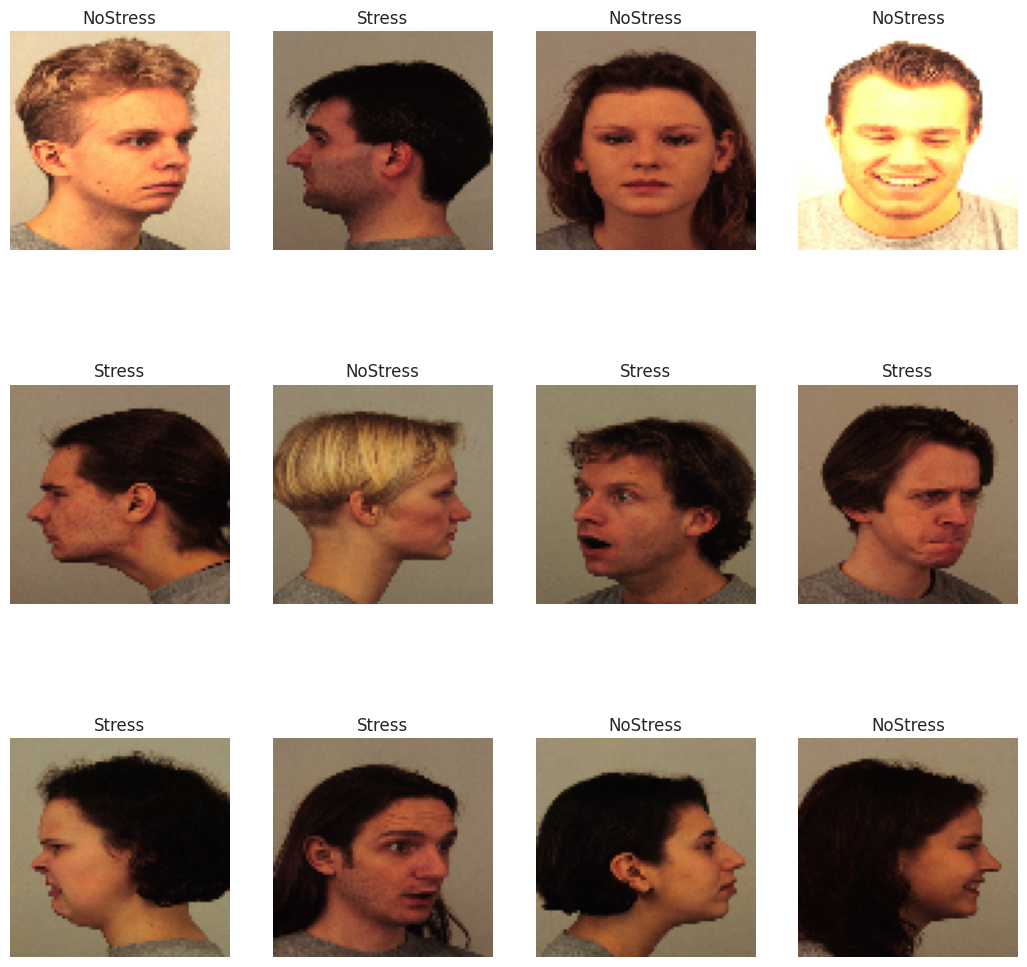

In [5]:
plt.figure(figsize = (13, 13))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('int32'))
        plt.title(dataset.class_names[labels[i].numpy()])
        plt.axis('off')

In [6]:
def train_val_split(data):
    train_data = data.take(int(len(data) * 0.9))
    val_data = data.skip(int(len(data) * 0.9)).take(int(len(data) * 0.1))
    return train_data, val_data

In [7]:
train_data, val_data = train_val_split(dataset)

In [8]:
test_data = keras.preprocessing.image_dataset_from_directory(
    directory = '/kaggle/input/stress-non-stress-images/KDEF/KDEF/Test',
    batch_size = 32,
    image_size = (80, 80),
    shuffle = True
)

Found 1891 files belonging to 2 classes.


In [9]:
print('The number of batches in the training dataset is:', len(train_data))
print('The number of batches in the test dataset is:', len(test_data))
print('The number of batches in the validation dataset is:', len(val_data))

The number of batches in the training dataset is: 124
The number of batches in the test dataset is: 60
The number of batches in the validation dataset is: 13


In [10]:
def normalization(data):
    normalized_data = data.map(lambda x, y: (x / 255, y))
    return normalized_data

In [11]:
train_data = normalization(train_data)

In [12]:
test_data = normalization(test_data)

In [13]:
val_data = normalization(val_data)

In [14]:
train_data = train_data.cache().shuffle(len(train_data)).prefetch(tf.data.AUTOTUNE)

In [15]:
test_data = test_data.cache().shuffle(len(test_data)).prefetch(tf.data.AUTOTUNE)

In [16]:
val_data = val_data.cache().shuffle(len(val_data)).prefetch(tf.data.AUTOTUNE)

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (80, 80, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [24]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [25]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [26]:
history = model.fit(train_data, epochs = 100, validation_data = val_data, callbacks = [early_stopping])

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5410 - loss: 0.6891 - val_accuracy: 0.7788 - val_loss: 0.4957
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7407 - loss: 0.5549 - val_accuracy: 0.7788 - val_loss: 0.4930
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7626 - loss: 0.5077 - val_accuracy: 0.7788 - val_loss: 0.4749
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7718 - loss: 0.4893 - val_accuracy: 0.7716 - val_loss: 0.4587
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7664 - loss: 0.4776 - val_accuracy: 0.8317 - val_loss: 0.4074
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7955 - loss: 0.4310 - val_accuracy: 0.8558 - val_loss: 0.3368
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8150 - loss: 0.3828 - val_accuracy: 0.9014 - val_loss: 0.2925
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8476 - loss: 0.3416 - val_acc

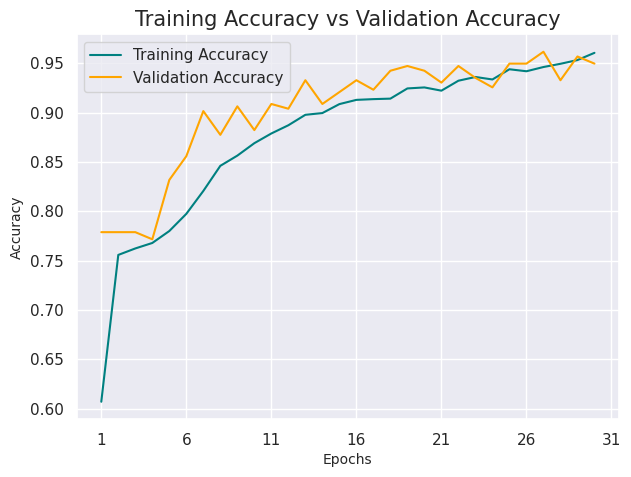

In [29]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(ticks = [0, 5, 10, 15, 20, 25, 30], labels = [1, 6, 11, 16, 21, 26, 31])
plt.legend()
plt.show()

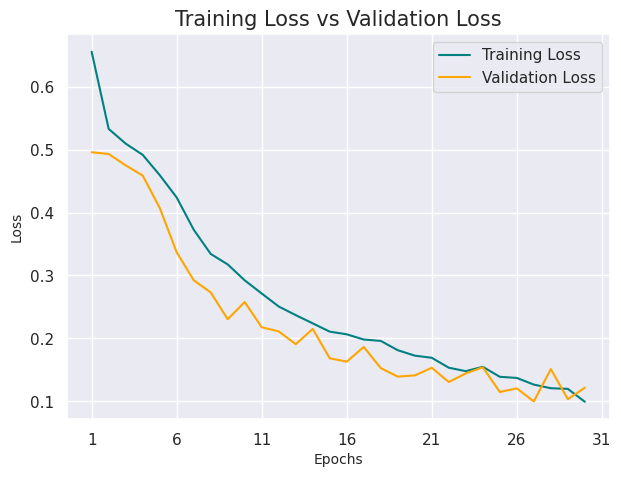

In [30]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.xticks(ticks = [0, 5, 10, 15, 20, 25, 30], labels = [1, 6, 11, 16, 21, 26, 31])
plt.legend()
plt.show()

In [31]:
model.evaluate(test_data)

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9269 - loss: 0.1703


[0.19397880136966705, 0.9217345118522644]

In [48]:
base_model1 = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [49]:
model2 = Sequential()

In [50]:
model2.add(base_model1)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(1, activation = 'sigmoid'))

In [51]:
model2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [52]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 3)

In [53]:
history2 = model2.fit(train_data, epochs = 100, validation_data = val_data, callbacks = [early_stopping2])

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 116s 137ms/step - accuracy: 0.7046 - loss: 0.8474 - val_accuracy: 0.4736 - val_loss: 12.4840
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8987 - loss: 0.2395 - val_accuracy: 0.7668 - val_loss: 1.2893
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9256 - loss: 0.1837 - val_accuracy: 0.8702 - val_loss: 0.5221
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9521 - loss: 0.1224 - val_accuracy: 0.7284 - val_loss: 1.2331
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9617 - loss: 0.0973 - val_accuracy: 0.9663 - val_loss: 0.0876
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9829 - loss: 0.0524 - val_accuracy: 0.8798 - val_loss: 0.3895
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9692 - loss: 0.0776 - val_accuracy: 0.9279 - val_loss: 0.2139
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9843 - loss: 0.048

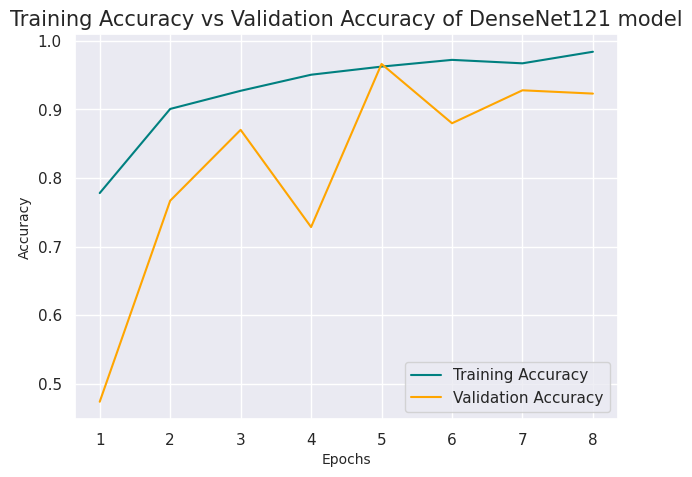

In [59]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy of DenseNet121 model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7], labels = [1, 2, 3, 4, 5, 6, 7, 8])
plt.legend()
plt.show()

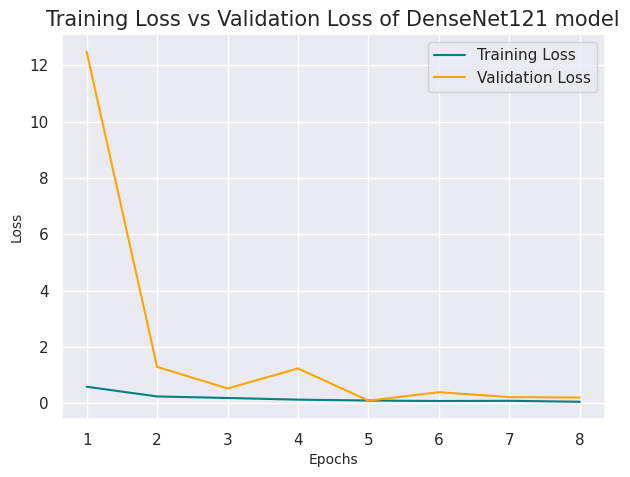

In [60]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss of DenseNet121 model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7], labels = [1, 2, 3, 4, 5, 6, 7, 8])
plt.legend()
plt.show()

In [61]:
model2.evaluate(test_data)

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9067 - loss: 0.2596


[0.25224941968917847, 0.9101004600524902]

In [81]:
base_model2 = ResNet50(weights = 'imagenet', include_top = False, input_shape = (80, 80, 3))

In [82]:
model3 = Sequential()

In [83]:
model3.add(base_model2)
model3.add(Flatten())
model3.add(Dense(1, activation = 'sigmoid'))

In [84]:
model3.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [85]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 3)

In [86]:
history3 = model3.fit(train_data, epochs = 100, validation_data = val_data, callbacks = [early_stopping3])

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 52s 93ms/step - accuracy: 0.6916 - loss: 1.6636 - val_accuracy: 0.5312 - val_loss: 8.9961
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7636 - loss: 0.5212 - val_accuracy: 0.5312 - val_loss: 0.9548
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.7783 - loss: 0.4504 - val_accuracy: 0.5312 - val_loss: 0.9348
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8301 - loss: 0.3588 - val_accuracy: 0.5312 - val_loss: 0.7608
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8935 - loss: 0.2472 - val_accuracy: 0.5433 - val_loss: 1.1499
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8749 - loss: 0.3340 - val_accuracy: 0.4688 - val_loss: 14592.2207
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.8722 - loss: 0.3020 - val_accuracy: 0.6635 - val_loss: 0.6520
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9199 - loss: 0.18

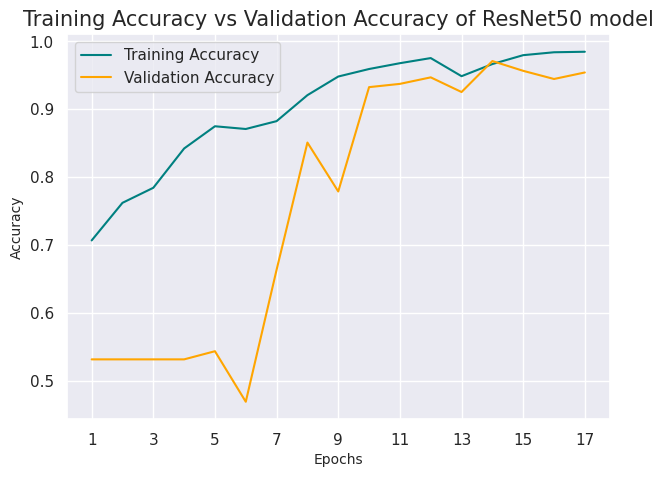

In [92]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history3.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy of ResNet50 model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.xticks(ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16], labels = [1, 3, 5, 7, 9, 11, 13, 15, 17])
plt.show()

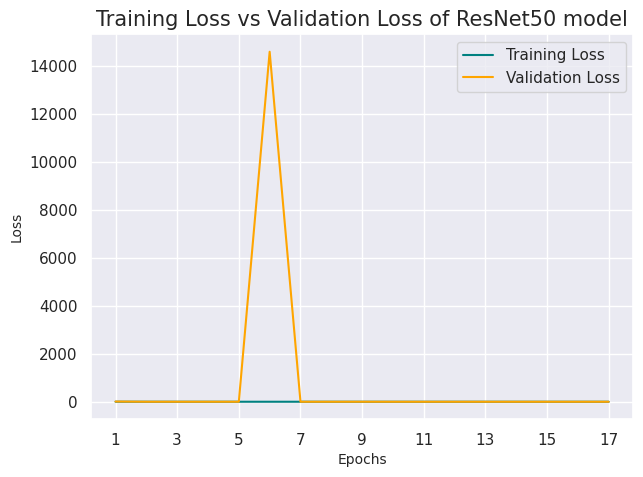

In [94]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history3.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss of ResNet50 model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.xticks(ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16], labels = [1, 3, 5, 7, 9, 11, 13, 15, 17])
plt.show()

In [95]:
model3.evaluate(test_data)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9330 - loss: 0.2516


[0.24328027665615082, 0.9291380047798157]